# Creating the dataset from MaNGa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
from astropy.io import fits

In [2]:
def plot_median(xdata, ydata, color):
    bins = np.arange(9, 12, 0.1)
    bins = 10**bins
    num_bins = len(bins)
    indx = np.digitize(xdata, bins)
    x_medians = np.array([np.median(xdata[indx == idx]) for idx in np.arange(num_bins) if len(xdata[indx == idx]) > 2])
    y_medians = np.array([np.median(ydata[indx == idx]) for idx in np.arange(num_bins) if len(xdata[indx == idx]) > 2])
    ax.plot(x_medians, y_medians, '-', lw=4, color='white')
    ax.plot(x_medians, y_medians, '-', lw=2, color=color, zorder=100)


### Loading the data

This is the data released from the combined analysis of the Dynamics and stellar Population (DynPop) for the MaNGA
survey in the final SDSS Data Release 17 (DR17). This MaNGA catalogue presents dynamically-determined quantities for
over 10000 nearby galaxies based on integral-field stellar kinematics from the MaNGA survey. The dynamical properties are
extracted using the axisymmetric Jeans Anisotropic Modelling (JAM) method. 
The catalog includes eight dynamical models with different assumptions: 

The use of two orientations of the velocity ellipsoid:
- (1) either cylindrically-aligned JAM (JAM_cyl)
- (2) or spherically-aligned JAM (JAM_sph).

The use of four assumptions for the models of dark vs. luminous matter distributions:
- (1) mass-follows-light,
- (2) free NFW dark halo,
- (3) cosmologically-constrained NFW halo,
- (4) generalized NFW dark halo, i.e. with free inner slope. In this catalogue, we provide


In [3]:
manga_dataset = fits.open('./raw_data/SDSSDR17_MaNGA_JAM.fits')
Yang07= np.genfromtxt('./raw_data/MaNGA_MPL11_Yang07.cat', dtype=None, skip_header=4, encoding='utf-8')
manga_M2L_SPS = np.genfromtxt('./raw_data/MaNGA_SPS_M2L.txt', dtype=None, skip_header=1)

Have a look at Cappellari (2008, 2020) for details of the JAM method, which uses the Multi-Gaussian Expansion (MGE; Emsellem
et al. 1994; Cappellari 2002) as parametrization for both the tracer population and the total density. As mentioned by Cappellari (2020),
different velocity ellipsoid assumptions may be appropriate for different types of galaxies.

In [4]:
Plate_IFU = manga_dataset[1].data['plateifu'] # Manga identifiers
manga_ID = manga_dataset[1].data['mangaid'] # Manga identifiers

loct = Yang07['f12']
Qual = manga_dataset[1].data['Qual'] # Visual Quality of JAM models, classified as -1, 0, 1, 2, 3 (worst to best). For this work Q=3 is recommended.
M_stellar = manga_dataset[1].data['Lum_tot_MGE'] + manga_M2L_SPS - 0.25 # logMstellar [Msun] Chabrier IMF
Reff = manga_dataset[1].data['Re_kpc_MGE'] # Reff [kpc] effective radius (projected half-light radius from MGE fitting in SDSS r-band)

fDM_NFW_JAMcyl = manga_dataset[4].data['fdm_Re'] # JAM_cyl + NFW
fDM_NFW_JAMsph = manga_dataset[5].data['fdm_Re'] # JAM_sph + NFW
fDM_fNFW_JAMcyl = manga_dataset[6].data['fdm_Re'] # JAM_cyl + fixed NFW
fDM_fNFW_JAMsph = manga_dataset[7].data['fdm_Re'] # JAM_sph + fixed NFW
fDM_gNFW_JAMcyl = manga_dataset[8].data['fdm_Re'] # JAM_cyl + gNFW
fDM_gNFW_JAMsph = manga_dataset[9].data['fdm_Re'] # JAM_sph + gNFW

quality_flag_jam = (Qual==3) # Recommended when looking at fDM
quality_flag_fdm = np.abs(fDM_gNFW_JAMcyl-fDM_gNFW_JAMsph) < 0.1 # Recommended to be sure the fDM is robust to the method
quality_flag_all = quality_flag_jam & (loct==1) & (~np.isnan(M_stellar)) & quality_flag_fdm

fDM = fDM_gNFW_JAMcyl[quality_flag_all]
M_stellar = 10**M_stellar[quality_flag_all]
Reff = Reff[quality_flag_all]
Plate_IFU = Plate_IFU[quality_flag_all]
manga_ID = manga_ID[quality_flag_all]
num_sample = len(M_stellar)

fDM_NFW_JAMcyl = fDM_NFW_JAMcyl[quality_flag_all]
fDM_NFW_JAMsph = fDM_NFW_JAMsph[quality_flag_all]
fDM_fNFW_JAMcyl = fDM_fNFW_JAMcyl[quality_flag_all]
fDM_fNFW_JAMsph = fDM_fNFW_JAMsph[quality_flag_all]
fDM_gNFW_JAMcyl = fDM_gNFW_JAMcyl[quality_flag_all]
fDM_gNFW_JAMsph = fDM_gNFW_JAMsph[quality_flag_all]


In [5]:
manga_dataset.close()

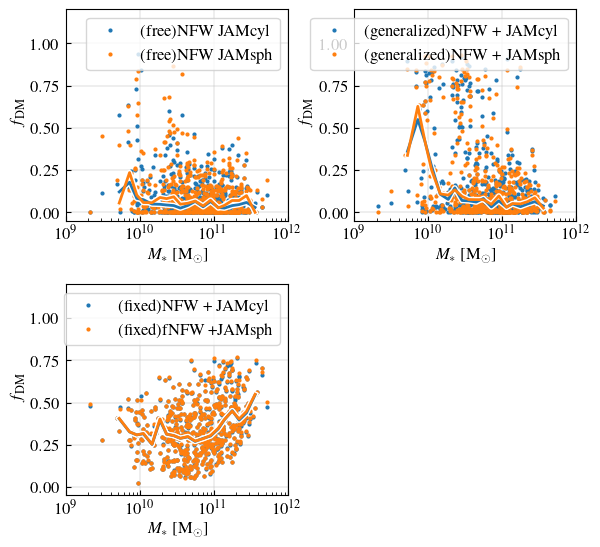

In [7]:
#################
# Plot parameters
params = {
    "font.size": 12,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (6, 6),
    "figure.subplot.left": 0.12,
    "figure.subplot.right": 0.97,
    "figure.subplot.bottom": 0.12,
    "figure.subplot.top": 0.93,
    "figure.subplot.wspace": 0.3,
    "figure.subplot.hspace": 0.3,
    "lines.markersize": 2,
    "lines.linewidth": 1,
    "figure.max_open_warning": 0,
}
plt.rcParams.update(params)
plt.figure()
ax = plt.subplot(2, 2, 1)
plt.grid(linestyle='-', linewidth=0.3)

plt.plot(M_stellar, fDM_NFW_JAMcyl, 'o',label='(free)NFW JAMcyl')
plt.plot(M_stellar, fDM_NFW_JAMsph, 'o',label='(free)NFW JAMsph')
plot_median(M_stellar, fDM_NFW_JAMcyl, 'tab:blue')
plot_median(M_stellar, fDM_NFW_JAMsph, 'tab:orange')

plt.axis([1e9, 1e12, -0.05, 1.2])
plt.xscale('log')
plt.ylabel(r"$f_{\mathrm{DM}}$")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)
plt.legend(ncol=1)

ax = plt.subplot(2, 2, 2)
plt.grid(linestyle='-', linewidth=0.3)
plt.plot(M_stellar, fDM_gNFW_JAMcyl, 'o', label='(generalized)NFW + JAMcyl')
plt.plot(M_stellar, fDM_gNFW_JAMsph, 'o', label='(generalized)NFW + JAMsph')
plot_median(M_stellar, fDM_gNFW_JAMcyl, 'tab:blue')
plot_median(M_stellar, fDM_gNFW_JAMsph, 'tab:orange')


plt.axis([1e9, 1e12, -0.05, 1.2])
plt.xscale('log')
plt.ylabel(r"$f_{\mathrm{DM}}$")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)
plt.legend(ncol=1)

ax = plt.subplot(2, 2, 3)
plt.grid(linestyle='-', linewidth=0.3)

plt.plot(M_stellar, fDM_fNFW_JAMcyl, 'o',label='(fixed)NFW + JAMcyl')
plt.plot(M_stellar, fDM_fNFW_JAMsph, 'o',label='(fixed)fNFW +JAMsph')
plot_median(M_stellar, fDM_fNFW_JAMcyl, 'tab:blue')
plot_median(M_stellar, fDM_fNFW_JAMsph, 'tab:orange')

plt.axis([1e9, 1e12, -0.05, 1.2])
plt.xscale('log')
plt.ylabel(r"$f_{\mathrm{DM}}$")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)
plt.legend(ncol=1)

plt.show()

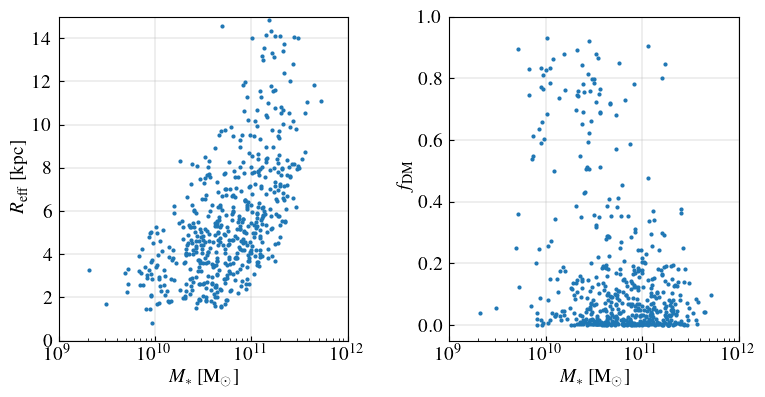

In [8]:
#################
# Plot parameters
params = {
    "font.size": 14,
    "font.family": "Times",
    "text.usetex": True,
    "figure.figsize": (8, 4),
    "figure.subplot.left": 0.12,
    "figure.subplot.right": 0.97,
    "figure.subplot.bottom": 0.12,
    "figure.subplot.top": 0.93,
    "figure.subplot.wspace": 0.35,
    "figure.subplot.hspace": 0.35,
    "lines.markersize": 2,
    "lines.linewidth": 1,
    "figure.max_open_warning": 0,
}
plt.rcParams.update(params)
plt.figure()
ax = plt.subplot(1, 2, 1)
plt.grid(linestyle='-', linewidth=0.3)
plt.plot(M_stellar, Reff, 'o')
plt.axis([1e9, 1e12, 0, 15])
plt.xscale('log')
plt.ylabel(r"$R_{\mathrm{eff}}$ [kpc]")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)

ax = plt.subplot(1, 2, 2)
plt.grid(linestyle='-', linewidth=0.3)
plt.plot(M_stellar, fDM, 'o')

plt.axis([1e9, 1e12, -0.05, 1])
plt.xscale('log')
plt.ylabel(r"$f_{\mathrm{DM}}$")
plt.xlabel("$M_{*}$ [M$_{\odot}$]")
ax.tick_params(direction='in', axis='both', which='both', pad=4.5)
plt.show()

### Making the final csv file

In [9]:
# Writing the data into a CSV file
with open('dataset/MANGA.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Writing the name line and the unit line
    writer.writerow(["PlateIFU", "MaNGAID", "M*[Msun]", "Reff[kpc]", "fDM(Reff)"])

    # Looping through each element of the data
    for i in range(num_sample):

        Mi = M_stellar[i]
        fDMi = fDM[i]
        Ri = Reff[i]
        Plate_i = Plate_IFU[i]
        ID_i = manga_ID[i]

        
        # Writing the data into the CSV file
        writer.writerow([Plate_i, ID_i, Mi, Ri, fDMi])

In [10]:
# Reading the CSV file into a DataFrame
manga = pd.read_csv('dataset/MANGA.csv')
manga

,PlateIFU,MaNGAID,M*[Msun],Reff[kpc],fDM(Reff)
0,7443-12705,12-84627,3.337476e+10,8.482,0.878
1,7495-12703,12-129646,2.668318e+10,5.917,0.514
2,7815-9101,1-113375,8.892178e+09,4.969,0.834
3,7815-12704,1-113418,4.371307e+10,5.303,0.028
4,8341-12701,1-282653,4.895284e+09,3.129,0.251
...,...,...,...,...,...
529,11965-9101,1-335268,1.312939e+11,5.825,0.071
530,12621-12703,1-415848,6.340040e+10,6.686,0.019
531,12674-12704,1-210403,2.530115e+11,7.566,0.363
532,11947-3703,1-135979,1.771741e+11,7.343,0.193
